# Visualise Trained Pytorch model and results

## Import libraries and plot training

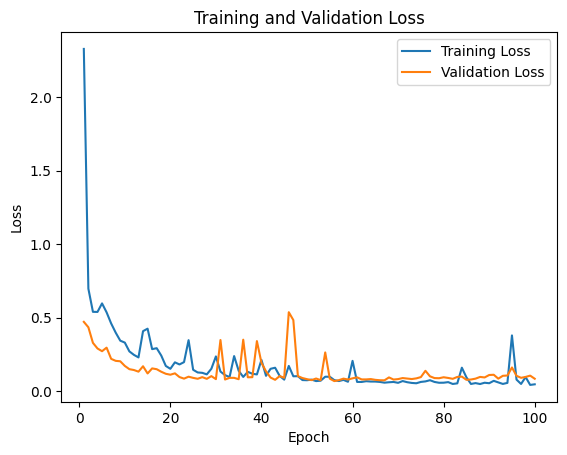

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import pandas as pd
from anytree import Node
from anytree.importer import JsonImporter
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
import numpy as np

# Read the training log file
training_log = pd.read_csv('training_log.csv')

# Plot the training and validation loss
plt.plot(training_log['Epoch'], training_log['Training Loss'], label='Training Loss')
plt.plot(training_log['Epoch'], training_log['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Extract test data

In [32]:
# %%
df = pd.read_parquet('/mnt/RAID/projects/FjordVision/segmented-objects-dataset.parquet')

# Assuming df is your DataFrame with all data
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load The Model and Ontology

In [42]:
importer = JsonImporter()
root = importer.read(open('ontology.json', 'r'))

classes_file = '/mnt/RAID/datasets/label-studio/fjord/classes.txt'

species_names = []
with open(classes_file, 'r') as file:
    species_names = [line.strip() for line in file]

genus_names = [node.name for node in root.descendants if node.rank == 'genus']
class_names = [node.name for node in root.descendants if node.rank == 'class']
binary_names = [node.name for node in root.descendants if node.rank == 'binary']

def get_hierarchical_labels(species_index, root):
    if species_index == -1:
        return -1, -1, -1  # Handle cases where species_index is invalid

    species_name = species_names[species_index]
    node = next((n for n in root.descendants if n.name == species_name), None)

    if node is None:
        return -1, -1, -1  # Species not found in the tree

    # Traverse up the tree to find genus, class, and binary ranks
    genus_index, class_index, binary_index = -1, -1, -1
    current_node = node

    while current_node.parent is not None:
        current_node = current_node.parent
        if current_node.rank == 'genus':
            genus_index = genus_names.index(current_node.name)
        elif current_node.rank == 'class':
            class_index = class_names.index(current_node.name)
        elif current_node.rank == 'binary':
            binary_index = binary_names.index(current_node.name)

    return genus_index, class_index, binary_index

# %%
class BranchCNN(nn.Module):
    def __init__(self, num_in_features, num_classes, num_additional_features):
        super(BranchCNN, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(num_in_features + num_additional_features, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, additional_features):
        x = x.view(x.size(0), -1)
        combined_input = torch.cat((x, additional_features), dim=1)
        return self.fc_layers(combined_input)


class HierarchicalCNN(nn.Module):
    def __init__(self, num_classes_hierarchy, num_additional_features):
        super(HierarchicalCNN, self).__init__()

        # Convolutional layers for feature extraction
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        ])

        # Branches for each convolutional layer output
        self.branches = nn.ModuleList([
            BranchCNN(128 * 64 * 64, num_classes_hierarchy[0], num_additional_features),  # Update sizes accordingly
            BranchCNN(256 * 32 * 32, num_classes_hierarchy[1], num_additional_features),
            BranchCNN(512 * 16 * 16, num_classes_hierarchy[2], num_additional_features),
            BranchCNN(512 * 8 * 8, num_classes_hierarchy[3], num_additional_features)
        ])

    def forward(self, x, conf, iou, pred_species):
        outputs = []
        additional_features = torch.cat((conf.view(-1, 1), iou.view(-1, 1), pred_species.view(-1, 1)), dim=1)

        for conv_layer, branch in zip(self.conv_layers, self.branches):
            x = conv_layer(x)
            branch_output = branch(x, additional_features)
            outputs.append(branch_output)

        return outputs

# Create a defaultdict to store the counts for each rank
rank_counts = defaultdict(int)

# Iterate over the nodes of the tree
for node in root.descendants:
    rank = node.rank
    rank_counts[rank] += 1

# Example instantiation of the model
num_classes_hierarchy = list(rank_counts.values())  # Example: [num_species, num_genus, num_class, num_binary]
num_additional_features = 3  # Assuming 3 additional features: conf, iou, pred_species

model = HierarchicalCNN(num_classes_hierarchy, num_additional_features)
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

# Load Dataloader

In [43]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, species_names, genus_names, class_names, binary_names):
        self.dataframe = dataframe
        self.species_names = species_names
        self.genus_names = genus_names
        self.class_names = class_names
        self.binary_names = binary_names

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = row['masked_image']
        # read image from path
        image = Image.open(image_path)
        image_resized = image.resize((128, 128))


        # Convert images to tensor
        image_tensor = torch.tensor(np.array(image_resized), dtype=torch.float32).permute(2, 0, 1) / 255.0  # Normalize if necessary

        # Convert additional features to tensor
        conf_tensor = torch.tensor(row['confidence'], dtype=torch.float32)
        iou_tensor = torch.tensor(row['iou_with_best_gt'], dtype=torch.float32)
  
        # Convert predicted species name to index
        pred_species_index = self.species_names.index(row['predicted_species']) if row['predicted_species'] in self.species_names else -1

        # Convert species names to indices and get hierarchical labels
        species_index = self.species_names.index(row['species']) if row['species'] in self.species_names else -1
        genus_index, class_index, binary_index = get_hierarchical_labels(species_index, root)

        return image_tensor, conf_tensor, iou_tensor, torch.tensor(pred_species_index), torch.tensor(species_index), torch.tensor(genus_index), torch.tensor(class_index), torch.tensor(binary_index)


test_dataset = CustomDataset(test_df, species_names, genus_names, class_names, binary_names)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Extract Predictions on test data

In [44]:
(test_df['predicted_species'] == test_df['species']).sum() / len(test_df)

0.9823966408268734

In [59]:
predictions = []
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

with torch.no_grad():
    for images, conf, iou, pred_species, species_index, genus_index, class_index, binary_index in test_loader:
        images, conf, iou, pred_species = images.to(device), conf.to(device), iou.to(device), pred_species.to(device)
        species_index, genus_index, class_index, binary_index = species_index.to(device), genus_index.to(device), class_index.to(device), binary_index.to(device)
